## Analysis & Prediction of Income Being Above or Below/Equal to $50,000 in Adult Census Data

By: Sunsar, Sarah, Emily, Calvin (DSCI 100 003 - Group 23)

Data is from: https://www.kaggle.com/datasets/uciml/adult-census-income

The dataset used for this analysis is derived from the 1994 Census Bureau database. 

The dataset contains a diverse range of numerical and categorical attributes, such as age, hours worked per week,  sex, and more. In this project, we will filter and simplify some categories from this dataset to discuss how certain factors affects an individual's likelihood of annual salary falls above or below/equal to $50,000.

The question this project will seek to answer is: 

**How do different aspects of a person predict whether annual income will be above or below/equal to $50K annually?**

# Reading in Data

In [1]:
library(tidyverse)
library(tidymodels)
library(glmnet)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.3     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
-- Attaching packages -------------------------------------- tidymodels 1.1.1 --

v broom        1.0.5     v rsample      1.2.0
v dials        1.2.0     v tune         1.1.2
v infer        1.0.5     v workflows    1.1.3
v modeldata    1.2.0     v workflowsets 1.0.1
v parsnip      1.1.1     v yardstick    1.2.0
v recipes      1.0.8     

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x scales::discard() masks purrr::discard()
x dplyr::filt

In [2]:
set.seed(123)

df = read_csv("https://raw.githubusercontent.com/calvingdu/dsci100-003-23/master/data/adult_census.csv")

# Splitting the data
df_split <- initial_split(df, prop = 0.8, strata = income)
df_train <- training(df_split)
df_test <- testing(df_split)

paste0("Training set row count: ", nrow(df_train))
paste0("Testing set row count: ", nrow(df_test))

Rows: 32561 Columns: 15
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (9): workclass, education, marital.status, occupation, relationship, rac...
dbl (6): age, fnlwgt, education.num, capital.gain, capital.loss, hours.per.week

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Training set row count: 26048"

[1] "Testing set row count: 6513"

In [3]:
head(df_train, 3)

age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K


# Tidying/Cleaning The Data & Selecting Columns
We can begin by tidying up the data. Something we noticed immediately that there are a lot of categorical columns. To tackle this, we plan to make buckets of categories and then turn them into dummy variables. For example, we can turn __sex__ into a dummy variable where 0 = male and 1 = female, or making a dummy variable for every unique value. 

These are the columns we plan to use and how we plan to tackle them to make them usable in data: 
- **Age**: No changes (either than scaling/imputation)
- **Education**: Simplified to a dummy variable of if College Graduate or Not
- **Occupation**: Make a dummy variable for all the occupations
- **Sex**: Transformed into a Dummy Variable
- **Capital Gain**: No changes (either than scaling/imputation)
- **Capital Loss**: No changes (either than scaling/imputation)
- **Hours Per Week**: No changes (either than scaling/imputation)
- **Native Country**: Turned into dummy variable of domestic (for the United States) since this data comes from the U.S Census Bureau

**Dropped Columns & Reasoning**: 
- race: Removed because of unequal sizing of race (such as 20k+ white people and only hundreds of the other races)
- fnlwgt: Unclear how this relates
- education.num: Already have education
- Workclass: Don"t believe this is significant to the study so removing to avoid overfitting since we have occupation
- marital.status: Don"t believe this is significant to the study so removing to avoid overfitting
- Relationship: Don"t believe this is significant to the study so removing to avoid overfitting


This is also some tidying to do. We can initially see that there are some missing values in __occupation__ represented as ?. Since we believe these are important roles to guess income category, we remove any rows that don't have data for this. 

In [4]:
filtered_df <- df_train |>
  select(age, education, occupation, sex,
         capital.gain, capital.loss, hours.per.week, native.country, income) |>
  filter(occupation != "?")

Then, we can begin by making dummy variables in the data using the above choices

### Binary Preprocessing

In [5]:
# Making a function to be used later
preprocess_binary <- function(df){
    transformed_df <- df |>
        mutate(college_grad = ifelse(education == 'Some-college'| education =='Masters'| education =='Bachelors' | education == "Prof-school",1,0)) |>
        mutate(female = ifelse(sex == "Female", 1, 0)) |>
        mutate(domestic = ifelse(native.country == "United-States", 1, 0))
    return(transformed_df)
}

binary_df <- preprocess_binary(filtered_df)

### Dummy Variables for Every Occupation

In [6]:
# Making a function to use later
preprocess_occupation <- function(df, occupations){
    for (occ in occupations) {
        col_name <- gsub("[^a-zA-Z0-9 ]", ".", tolower(occ))
        df[[col_name]] <- as.integer(df$occupation == occ)
    }
    return(df)
}

unique_occupations <- as.list(unique(binary_df$occupation))
tidy_df <- preprocess_occupation(binary_df, unique_occupations)
tidy_df <- tidy_df %>% mutate(income = as.factor(income))

Below is an function that does all of our pre-processing. It can be verified by checking if the changes we made above are the same as the changes made by the function

In [7]:
process_df <- function(df){
  filtered_df <- df |>
  select(age, education, occupation, sex,
         capital.gain, capital.loss, hours.per.week, native.country, income) |>
  filter(occupation != "?")

  binary_df <- preprocess_binary(filtered_df)

  unique_occupations <- as.list(unique(binary_df$occupation))
  occupations_df <- preprocess_occupation(binary_df, unique_occupations)
    
  tidy_df <- occupations_df %>% mutate(income = as.factor(income))
  return(tidy_df)
}

processed_df_train <- process_df(df_train)
print(all.equal(processed_df_train, tidy_df) & all.equal(colnames(processed_df_train), colnames(tidy_df)))

[1] TRUE


# Exploratory Data Analysis



## 1. How Domestic Status and Education Affects Income

"In 1997, the wage premium was 63%  for a university degree, and it was 20% for other types of higher education" (Park et al., 2020)

This quote states that graduates with a university degree will have a 63% wage premium compared to those without. This essentially means that those with a degree have higher earning potential than those without. Additionally, 

Sarah Bohn and Eric Schiff state in an article that "On average, immigrants earn less than native-born workers. Nationwide, the hourly wages of immigrants are 12% lower than the hourly wages of American-born workers" (Bohn & Schiff, 2011). 

These two characteristics are key factors in defining an individual. We can explore how these variables affect a person's income and whether they interact at all.

`summarise()` has grouped output by 'domestic'. You can override using the
`.groups` argument.


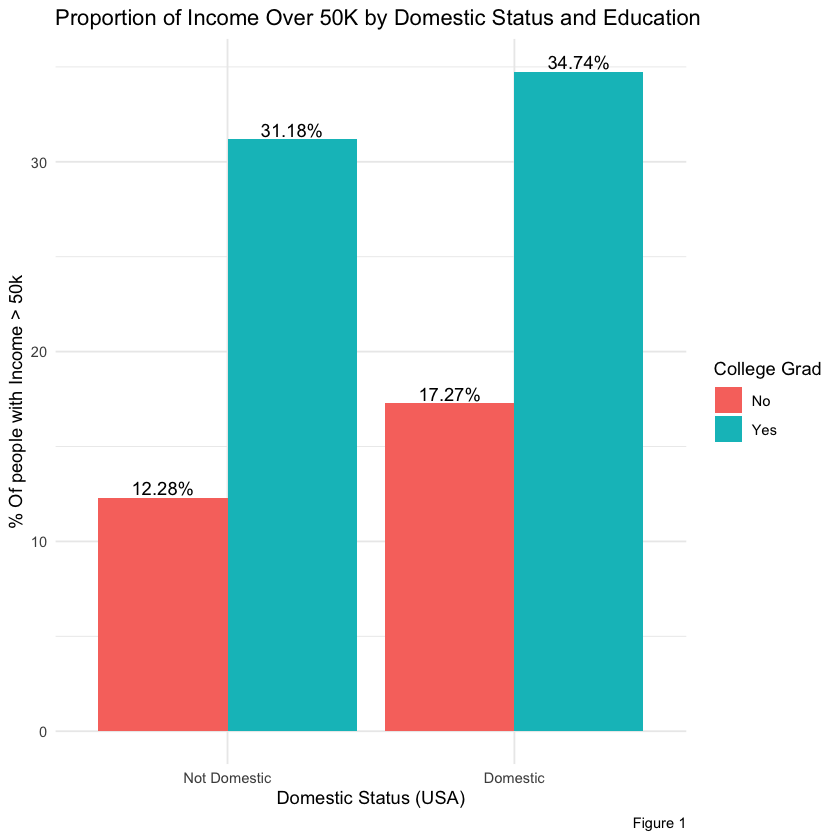

In [8]:
data <- tidy_df %>%
  group_by(domestic, college_grad) %>%
  summarize(proportion = (sum(income == ">50K") / n()) * 100) %>%
  ungroup() %>%
  mutate(domestic = factor(domestic, labels = c("Not Domestic", "Domestic")),
         college_grad = factor(college_grad, labels = c("No", "Yes")))

ggplot(data, aes(x = domestic, y = proportion, fill = college_grad)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(y = "% Of people with Income > 50k", x = "Domestic Status (USA)", title = "Proportion of Income Over 50K by Domestic Status and Education", fill = "College Grad", caption = "Figure 1") +
  theme_minimal() +
  geom_text(aes(label = sprintf("%.2f%%", proportion)), 
            position = position_dodge(width = 0.9), 
            vjust = -0.25)

This visualization indicates that having a college degree is associated with a higher proportion of individuals earning over \$50,000, regardless of domestic status. Additionally, domestic individuals exhibit a higher proportion of individuals earning over \$50,000 in both categories. This supports the assertion that domestic individuals are more likely to earn over \$50,000 than immigrant individuals, implying a correlation between domestic status and higher income levels. However, it is noteworthy that education seems to exert a more substantial impact on income than domestic status, given that the increase in income proportion for college graduates is more significant than the increase observed between different domestic statuses.

## 2. How Occupation Affects Income

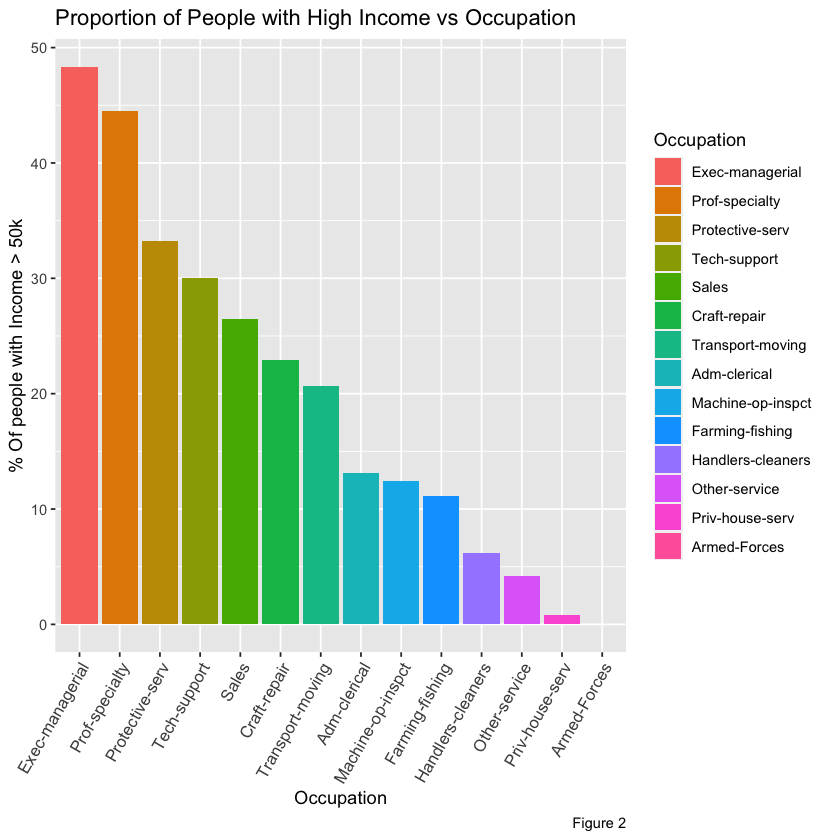

In [9]:
tidy_df %>% 
group_by(occupation) %>% 
summarize(proportion = (sum(income == ">50K") / n()) * 100) %>%
ggplot(aes(x = reorder(occupation, -proportion), y = proportion, fill = reorder(occupation, -proportion))) +
geom_bar(stat = "identity") +
labs(x = "Occupation", y = "% Of people with Income > 50k", title = "Proportion of People with High Income vs Occupation", fill = "Occupation", caption = "Figure 2") +
theme(axis.text.x = element_text(size = 10, angle = 60, hjust = 1))

The primary objective of this graph is to analyze the relationship between people’s income and their occupation. The data is visualized using a bar plot, with each occupation represented in a different color for effective visualization. The x-axis represents the occupation of the people, while the y-axis represents the percentage of people whose annual income is >= $50,000 in a specific occupation. There were 14 different types of occupations in the dataset, with executive managers forming the greatest percentage of people in the list and private house servers having the least percentage of people with high income.

We can observe that occupations typically associated with high pay (white-collar jobs) have the highest proportion of people with income > $50,000, and this proportion decreases as we move into manual labor work. This showcases that the type of job will have a significant impact on whether or not people can meet this income threshold.


## 3. How Sex Affects High Income
*"There are sizeable earnings differentials by both gender and race in the U.S. labor market, with women earning less than men"* (Greenman & Xie, 2008)

This article asserts a correlation between sex and income class. We can explore our dataset to see how the patterns here compare to this claim. 

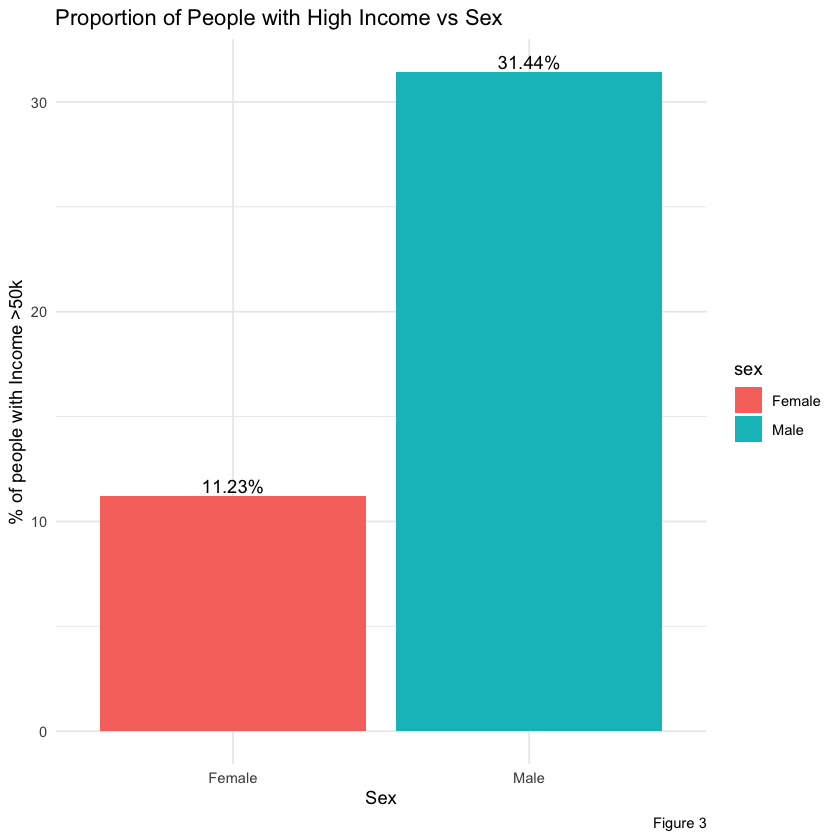

In [10]:
tidy_df %>% 
  group_by(sex) %>%
  summarize(proportion = (sum(income == ">50K") / n()) * 100) %>% 
  ggplot(aes(x = sex, y = proportion, fill = sex)) +
  geom_bar(stat = "identity") +
  labs(x = 'Sex', y = "% of people with Income >50k", title = "Proportion of People with High Income vs Sex", caption = "Figure 3") + 
  theme_minimal() +
  geom_text(aes(label = sprintf("%.2f%%", proportion)), 
            position = position_dodge(width = 0.9), 
            vjust = -0.25)

Greenman and Xie discuss gender-based wage gaps, consistently finding that men earn more than women (2018). Their work is supported by previous papers, indicating a persistent pattern of gender differences resulting in earning inequalities. 

Our dataset categorizes yearly income as greater than or less than/equal to \$50,000 annually. The graph supports the claims made by the Greenman and Xie paper, as our data indicates that a higher percentage of males (about 31%) earn more than \$50,000 per year compared to about 11% of females achieving that threshold.

## 4. How Age Affects High Income

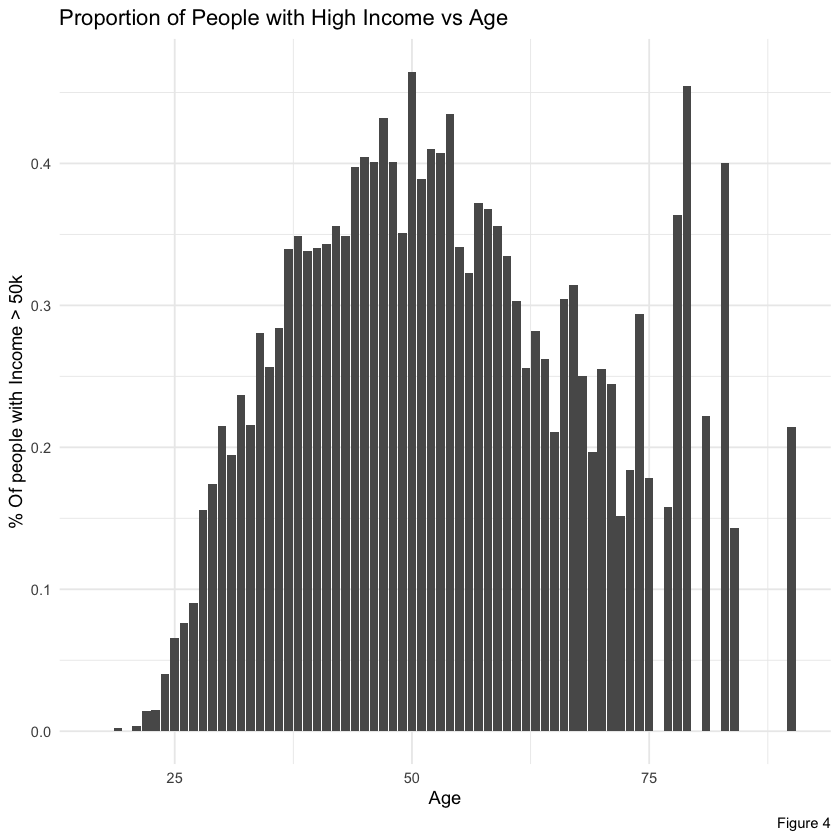

In [11]:
age_plot <- tidy_df %>%
  group_by(age) %>%
  summarise(proportion = sum(income == ">50K") / n()) |>
    ggplot(aes(x = age, y = proportion)) +
    geom_bar(stat = "identity") +
    labs(x = "Age", y = "% Of people with Income > 50k", caption = "Figure 4") +
    ggtitle("Proportion of People with High Income vs Age") + 
    theme_minimal()
  
  age_plot

Aiming to understand the relationship between age and people’s income greater than 50K, we visualized the data with a bar plot, leading to the following observations:
1. Between the ages 20 to 75, the distribution appears close to unimodal, which peaks at about 50. After 75, we start seeing outliers, suggesting another peak
2. The primary peak around age 50 implies that, at this age, more people have an income  >50k, representing the highest proportion of individuals with that income
3. The age range of the plot spans from 20 to 80. However, the plot has outliers after the age of 75 that require further exploration

In [12]:
occ_data <- tidy_df %>% 
filter(age > 75) %>%  
select(age, occupation) %>% 
group_by(occupation) %>% 
summarize (count_occ = n()) %>% 
arrange(-count_occ)

occ_data

occupation,count_occ
<chr>,<int>
Exec-managerial,25
Prof-specialty,17
Sales,17
Adm-clerical,16
Other-service,15
Craft-repair,11
Farming-fishing,11
Machine-op-inspct,5
Priv-house-serv,5


At the age of 75, the bar plot has an inflection point, which marks a shift in shape from decreasing to increasing. To investigate what aspects influence the data after 75, we decided to focus on occupations to gain more information. Using the information above, we examined the counts of each occupation with an income over 50K for people older than 75 to make further observations. 

We can see people older than 75 typically hold jobs such as executive managers, sales professionals, and other high-paying jobs. This observation explains the high proportion at this age, as these people are at the top of their fields, earning high salaries. The increasing shape of plot after age 75 can be explained by occupations people older than 75 have, such as executive managers. This clarifies the trends seen in the plot. Apart from these points, the plot initially increases, then after about age 50, it decreases. 

Therefore, people under the age of 50 get higher income peaking around 50, and then after 50 this trend reverses as age increases unless they hold a tenured position, such as executive managers/professors.

## 5. How Capital Gain/Capital Loss Affects High Income

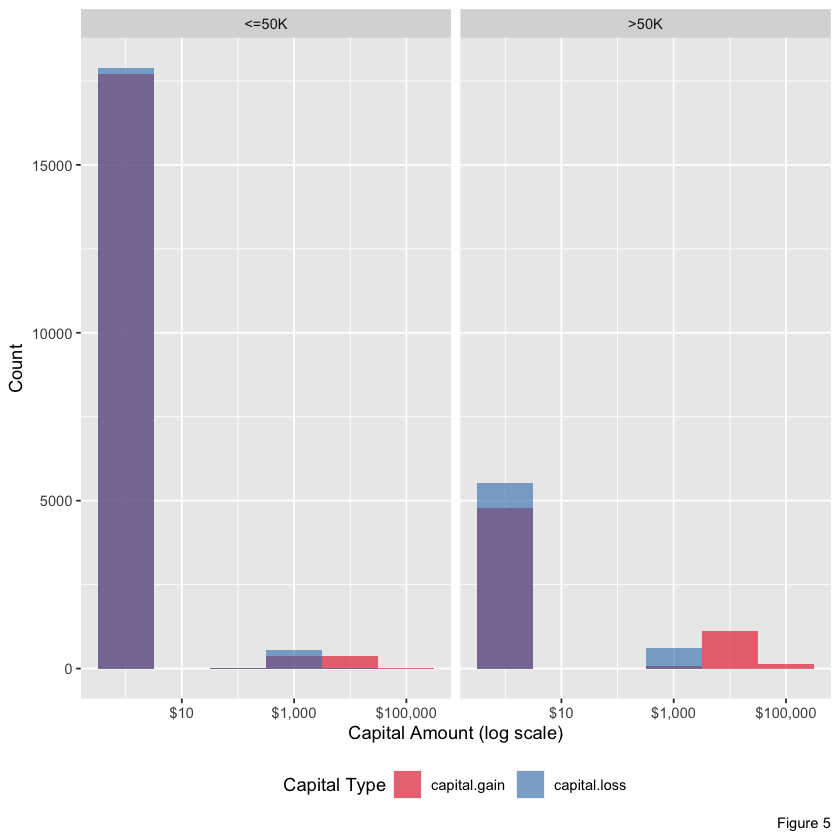

In [13]:
long_data <- tidy_df %>%
  pivot_longer(cols = c(capital.gain, capital.loss),
               names_to = "capital_type",
               values_to = "amount") %>%
               mutate(amount = if_else(amount == 0, 1, amount))

ggplot(long_data, aes(x = amount, fill = capital_type)) +
  geom_histogram(binwidth = 1, position = "identity", alpha = 0.6) +
  scale_x_log10(labels = scales::label_dollar()) +
  facet_wrap(~income) +
  labs(x = "Capital Amount (log scale)", y = "Count", fill = "Capital Type", caption = "Figure 5") +
  theme(legend.position = "bottom") + 
  scale_fill_brewer(palette = "Set1", name = "Capital Type")

This histogram shows that individuals with higher capital gains are more prevalent in the >50K income bracket, suggesting a positive correlation between capital gains and higher income levels. Conversely, capital loss does not show much information and seems to have a lot less statistical significance. The dense clustering of individuals with minimal capital gains/losses, predominantly in the <=50K category, might imply less engagement with capital markets among lower-income earners in general. Overall, the visual data suggests that capital gains are a more significant predictor of higher income than capital losses, and people in the <=50K category generally do not deal with the markets.

----

## 6. How Hours Per Week Affects High Income

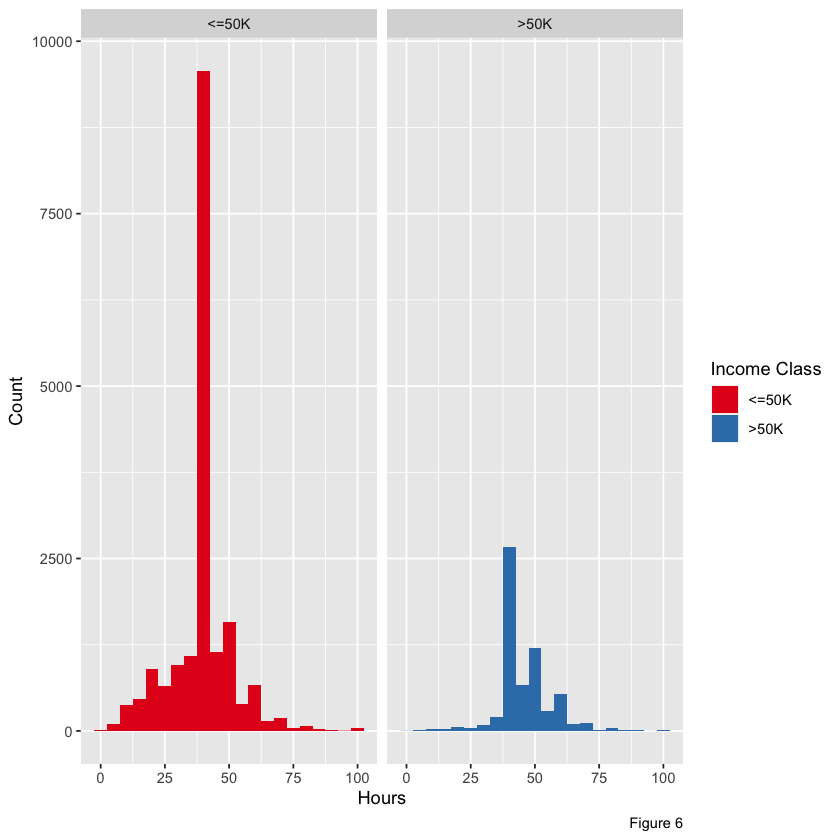

In [14]:
ggplot(tidy_df, aes(x = hours.per.week, fill = income)) +
  geom_histogram(binwidth = 5, position = "identity") +
  facet_wrap(~income) +
  labs(x = "Hours", y = "Count", caption = "Figure 6") + 
  scale_fill_brewer(palette = "Set1", name = "Income Class")

We can see that the main differences in these plots are for people who work less than 40 hours per week. There is almost nobody who works less than 40 in the >50k income class but there is a sizable amount in the <=50k class. This gives us indication that if someone works less than 40 hours they are more likely to be in the <=50k income class.

# Model Building

In [15]:
train_df <- process_df(df_train)
test_df <- process_df(df_test)

colnames(train_df)

[1] "age"               "education"         "occupation"       
 [4] "sex"               "capital.gain"      "capital.loss"     
 [7] "hours.per.week"    "native.country"    "income"           
[10] "college_grad"      "female"            "domestic"         
[13] "exec.managerial"   "machine.op.inspct" "prof.specialty"   
[16] "adm.clerical"      "sales"             "transport.moving" 
[19] "craft.repair"      "other.service"     "farming.fishing"  
[22] "protective.serv"   "tech.support"      "handlers.cleaners"
[25] "priv.house.serv"   "armed.forces"

In [16]:
log_reg_model <- logistic_reg(mixture = double(1), penalty = double(1)) %>%
  set_engine("glmnet") %>%
  set_mode("classification")

log_reg_recipe <- recipe(income ~ age + hours.per.week + income + college_grad
                         + female + domestic + capital.gain + capital.loss
                         # occupations
                         + exec.managerial + machine.op.inspct + prof.specialty
                         + adm.clerical + sales + transport.moving
                         + craft.repair + other.service + farming.fishing
                         + protective.serv + tech.support + handlers.cleaners
                         + priv.house.serv + armed.forces,
                         data = tidy_df) %>%
  step_scale(all_numeric_predictors()) %>%
  step_center(all_numeric_predictors())

log_reg_fit <- workflow() %>%
  add_recipe(log_reg_recipe) %>%
  add_model(log_reg_model) %>%
  fit(data = train_df)

model_summary <- tidy(log_reg_fit)
model_summary %>% arrange(-abs(estimate))

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),-1.43799809,0
capital.gain,1.12747885,0
female,-0.51329059,0
age,0.48896599,0
hours.per.week,0.37470797,0
other.service,-0.31943338,0
prof.specialty,0.29765814,0
exec.managerial,0.29141907,0
college_grad,0.26525314,0


Looking at the coefficients of the logistical regression model, this matches up with our analysis, in what we perceived to be significant. For example capital gain is a very strong predictor, alongside with sex, age and some occupations.

We can see that some occupations are not very statistically significant. This also relates to some variables such as "domestic" which is what we expected.

Something unexpected was hours.per.week which we didn't think would have a lot of impact but has a large coefficient. We believed occupation would be much more important but hours.per.week had more impact on the model.


--- 
## Conclusion

From all of our analysis/visualizations above and our model coefficients, we can conclude what we found were significant factors to predict income class: 

- **Age**: There is clear indication that as age increases, a person is more likely to have an income >50K. This is likely a statistically significant indicator for predicting the income class

- **College Grad**: Also important, we found that being a college grad or not will significantly impact the indication of income class as there is large discrepancies between proportion
- **Domestic Status (American)**: Domestic status is not as strong of an indicator, there is a bit of a difference but it doesn't seem to have much significance
- **Occupation**: Some occupations such as Executive Manager and Profs have a significant proportion with income >50k. This in conjunction with occupations such as Armed-Forces (which has 0% of people with income >50k) indicate that some occupations will be significant in determining income class. The other occupations also have some significance but not as much the ones we see on the high/low extremes.

- **Sex**: There is a consistent trend that males are more likely to be in the >50k income class showing strong statistical signifiance in predicting income class 
- **Capital Gain**: Capital gain shows a strong indicator for being in the >50k income class. There's a higher count of people with a sizable capital gain in the >50k income class
- **Capital Loss**: Capital loss does not show a significant trend but something to note is that more people in the <=50k income class have 0 capital gain or loss which could mean that having any capital gain or loss (any capital investment at all) indicates being in the income >50k
- **Hours Per Week**: There is almost nobody who works less than 40 in the >50k income class but there are a sizable amount in the <=50k class. This indicates that if someone works less than 40 hours they are more likely to be in the <=50k income class

Based on our observations, it can be concluded that:

1. College graduates form the greatest proportion of people earning >50K in income. Hence, more people may aim towards a college degree.
2. Furthermore, executive managers and sales managers earn a significantly greater income compared to other occupations, so we may see an increase in the number of people applying for these jobs. 
3. There is a significant difference in the salary earned between Males and Females, hence the government may try to implement policies to reduce the pay gap.
4. There was also a positive  correlation between the working hours and the salary of a person. Therefore, people may spend more hours at work in order to get a greater income. 

Some further questions that may be explored from this: 
1. Some of these characteristics such as age and the level of education have intuitive reasoning as to why there isn't an equal proportion of people with high income, but why is it that characteristics like sex have such a substantial impact on whether or not a question can have an income above 50k? 

2. Is there a way to reduce the drastic differences in pay between the various occupations? Why do some occupations have much more signifiance impact than others?

--- 
### Model Results
Just for fun, this was the model results on a testing set: 

In [17]:
train_df <- process_df(df_train)
test_df <- process_df(df_test)

get_model_metrics <- function(fit, df){
  metrics <- predict(fit, df) %>%
    bind_cols(df) %>%
    mutate(truth = as.factor(income),
           estimate = as.factor(.pred_class)) %>%
    metrics(truth = truth, estimate = estimate)

  return(metrics)
}

train_accuracy <- get_model_metrics(log_reg_fit, train_df) %>%
  filter(.metric == "accuracy") %>%
  select(.estimate) %>%
  pull(1)

test_accuracy <- get_model_metrics(log_reg_fit, test_df) %>%
  filter(.metric == "accuracy") %>%
  select(.estimate) %>%
  pull(1)


paste0("Training Accuracy: ", round(train_accuracy, 3))
paste0("Testing Accuracy: ", round(test_accuracy, 3))

[1] "Training Accuracy: 0.814"

[1] "Testing Accuracy: 0.816"

---

## References Cited (APA)
- Park, Y., Kyui, N., &amp; Galassi, G. (2020, October 7). Learning and earning. Bank of Canada. https://www.bankofcanada.ca/2020/10/learning-and-earning/#:~:text=How%20much%20more%20you%20earn,skills%20you%20learned%20in%20school 

- Bohn, S., &amp; Schiff, E. (2011, March 1). Immigrants and the labor market. Public Policy Institute of California. https://www.ppic.org/publication/immigrants-and-the-labor-market/#:~:text=On%20average%2C%20immigrants%20earn%20less,is%20much%20larger%20(26%25). 

- Greenman, E., & Xie, Y. (2008). Double Jeopardy? The Interaction of Gender and Race on Earnings in the U.S. Social forces; a scientific medium of social study and interpretation, 86(3), 1217–1244. https://doi.org/10.1353/sof.0.0008